# Data exploration 

In [1]:
import_train_data_path = r'C:\Users\yaschuk\Desktop\12\Train.csv'
import_test_data_path = r'C:\Users\yaschuk\Desktop\12\Test.csv'
export_results_path = r'C:\Users\yaschuk\Desktop\12\decisions.csv'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import fbeta_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import pyplot
from sklearn import datasets, metrics, model_selection, svm


from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [4]:
df2 = pd.read_csv(import_train_data_path, delimiter=',', header= None).replace('"','', regex=True).replace(',',';', regex=True)
df2 = df2.iloc[:,0].str.split(';', expand=True)

df2.columns = df2.iloc[0]
df2 = df2.drop(index=0).reset_index(drop=True)

In [5]:
df2.head()

,Status,Seniority,Time,Age,Marital,Records,Expenses,Income,Assets,Debt,Amount,Price,ResidenceType,EmploymentType,ApplicationId,PhoneNumber
0,bad,1,48,22,1,no_rec,35,,10000,0,650,722,5,3,3604,183158086037
1,good,30,48,52,2,no_rec,90,300,12000,0,1700,1734,6,3,1506,801344057881
2,bad,4,36,24,2,no_rec,55,100,0,0,650,725,1,2,4047,323767793678
3,good,25,36,54,2,yes_rec,45,285,7000,0,900,1383,2,3,5418,285277752797
4,bad,2,36,23,1,no_rec,43,79,0,0,900,1000,1,1,3381,108826052722


In [7]:
#check Nulls & empty in the train data
pd.concat([df2.isnull().sum(),df2.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
0,,
Status,0,1
Seniority,0,0
Time,0,0
Age,0,0
Marital,0,0
Records,0,0
Expenses,0,0
Income,0,297
Assets,0,37


In [8]:
df2 = df2[df2['Status'] != '']

In [9]:
for cat_var in ['Status', 'Records']:
    print(cat_var, ":", df2[cat_var].unique())

Status : ['bad' 'good']
Records : ['no_rec' 'yes_rec']


In [10]:
#transform categorical Records 
lb = preprocessing.LabelBinarizer()


for cat_var in ['Records']:
    df2[cat_var] = lb.fit_transform(df2[cat_var])
    
#transform categorical Status
df2['Status'] = [1 if x == 'bad' else 0 for x in df2['Status']]

In [11]:
#replace empty with nulls 
df2 = df2.replace(r'^\s*$', np.nan, regex=True).astype(float)

In [12]:
df2.sort_values(by='Status', ascending=False).count()

0
Status            3563
Seniority         3563
Time              3563
Age               3563
Marital           3563
Records           3563
Expenses          3563
Income            3266
Assets            3526
Debt              3548
Amount            3563
Price             3563
ResidenceType     3557
EmploymentType    3561
ApplicationId     3563
PhoneNumber       3563
dtype: int64

In [13]:
#check the decoration
df2.columns

Index(['Status', 'Seniority', 'Time', 'Age', 'Marital', 'Records', 'Expenses',
       'Income', 'Assets', 'Debt', 'Amount', 'Price', 'ResidenceType',
       'EmploymentType', 'ApplicationId', 'PhoneNumber'],
      dtype='object', name=0)

In [14]:
df2.describe()

,Status,Seniority,Time,Age,Marital,Records,Expenses,Income,Assets,Debt,Amount,Price,ResidenceType,EmploymentType,ApplicationId,PhoneNumber
count,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3563.000000,3266.000000,3526.000000,3548.000000,3563.000000,3563.000000,3557.000000,3561.000000,3563.000000,3.563000e+03
mean,0.285434,8.041819,46.669660,36.991299,1.874544,0.175133,55.575077,141.729026,5297.038287,355.074126,1039.079989,1460.487791,2.661231,1.670317,3227.913556,3.172489e+11
std,0.451684,8.160428,14.664182,10.916131,0.631594,0.380134,19.364269,81.988961,10676.369042,1230.616528,471.745732,631.571814,1.606264,0.945859,1286.908206,2.134263e+11
min,0.000000,0.000000,6.000000,18.000000,1.000000,0.000000,35.000000,6.000000,0.000000,0.000000,100.000000,105.000000,1.000000,1.000000,1002.000000,1.000463e+11
25%,0.000000,2.000000,36.000000,28.000000,2.000000,0.000000,35.000000,90.000000,0.000000,0.000000,700.000000,1118.500000,2.000000,1.000000,2111.500000,1.797408e+11
50%,0.000000,5.000000,48.000000,35.000000,2.000000,0.000000,50.000000,125.000000,3000.000000,0.000000,1000.000000,1400.000000,2.000000,1.000000,3231.000000,2.528251e+11
75%,1.000000,12.000000,60.000000,45.000000,2.000000,0.000000,72.500000,170.000000,6000.000000,0.000000,1300.000000,1693.500000,3.000000,3.000000,4337.500000,3.295835e+11
max,1.000000,47.000000,72.000000,68.000000,5.000000,1.000000,180.000000,959.000000,300000.000000,30000.000000,4500.000000,11140.000000,6.000000,4.000000,5454.000000,9.999226e+11


In [15]:
# Feature PhoneNumber does not give any information to the model. I assume that can create new feature out of Phone number,
#that contains first digit of phone number. It can provide information about the location of the customer

df2['PhoneNumber2'] = df2['PhoneNumber'].astype(str).str[:1]
df2.drop("PhoneNumber",axis=1,inplace=True)

df2.groupby(['PhoneNumber2']).size().sort_values(ascending=False)

PhoneNumber2
2    1191
1    1140
3     540
6     130
8     125
5     118
7     109
9     107
4     103
dtype: int64

In [16]:
#predicted feature 'Status' has imbalanced data
df2.groupby(['Status']).size().sort_values(ascending=False)

Status
0.0    2546
1.0    1017
dtype: int64

c:\users\yaschuk\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


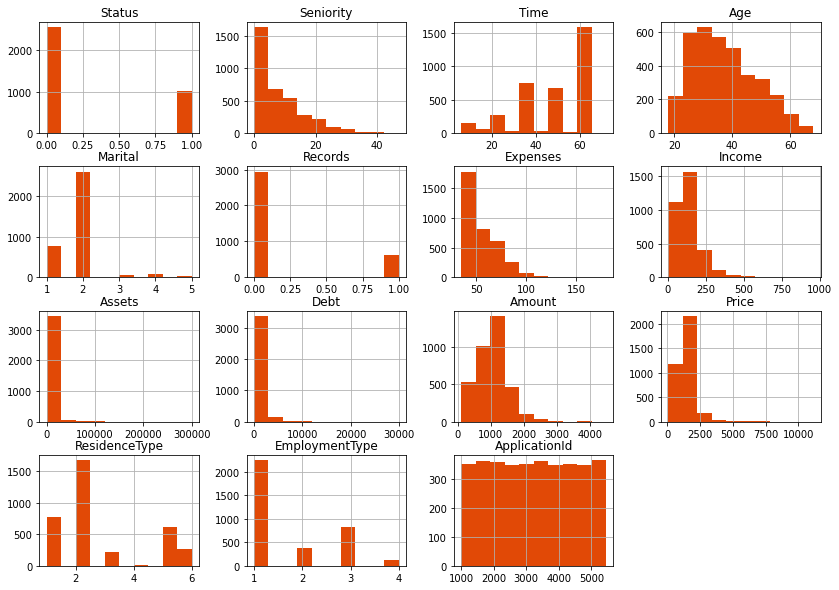

In [17]:
df2.hist(bins=10, figsize=(14,10), color='#E14906')
plt.show()

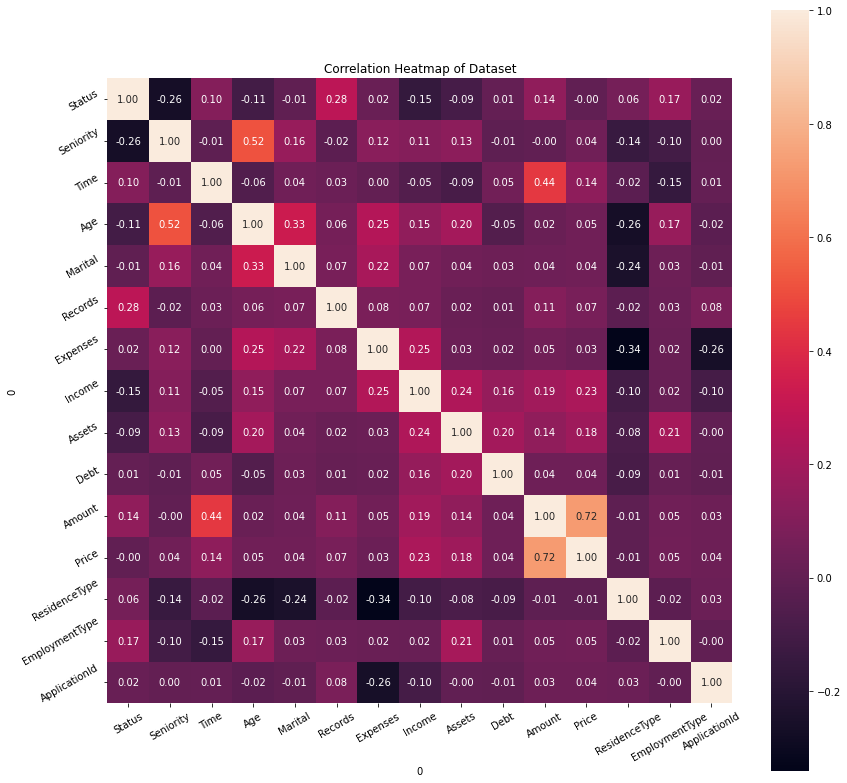

In [18]:
corr_matrix = df2.corr()

# Create correlation heatmap
plt.figure(figsize=(14,14))
plt.title('Correlation Heatmap of Dataset')
a = sns.heatmap(corr_matrix, square=True, annot=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()    